# Automated CryoSPARC Processing

To execute this script, ensure you have downloaded a set of movie images from EMPIAR. This guide demonstrates how to automate CryoSPARC data processing using Python.

In [23]:
import sys, os
project_root = os.path.dirname(os.path.abspath('.'))
if project_root not in sys.path:
    sys.path.append(project_root)
print(f"{project_root = }")
from CryoCRAB import *
import logging
logging.getLogger().setLevel(logging.DEBUG)
logging.getLogger("pymongo").setLevel(logging.WARNING)
from IPython.display import Markdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

project_root = '/home/vrlab/code/Cryo/CryoCRAB-Scripts'


In [2]:
# os.environ["CRYOSPARC_LICENSE_ID"] = None
# os.environ["CRYOSPARC_MASTER_HOSTNAME"] = None
# os.environ["CRYOSPARC_BASE_PORT"] = None
# os.environ["CRYOSPARC_EMAIL"] = None
# os.environ["CRYOSPARC_PASSWORD"] = None
# os.environ["CRYOSPARC_PROJECT_ID"] = None
from CryoCRAB.utils.cryosparc import get_cryosparc_client, \
    get_cryosparc_job, get_cryosparc_project, get_cryosparc_workspace, get_cryosparc_job_link
cs = get_cryosparc_client()
project_id = os.getenv("CRYOSPARC_PROJECT_ID", None)
cs_project = get_cryosparc_project(project_id)
workspace_id = os.getenv("CRYOSPARC_WORKSPACE_ID", None)
cs_workspace = get_cryosparc_workspace(workspace_id)
print(f"{project_id = }, {workspace_id = }")

project_id = 'P10', workspace_id = 'W2'


## Prepare Dataset Metadata

You can either manually set the metadata (e.g., `/path/to/movie`, `/path/to/gain`, or other microscope parameters) or retrieve it from a MongoDB database. For simplicity, we demonstrate the custom setting approach here. We use the widely known dataset EMPIAR-10002 as an example.

In [3]:
accel_kv = 300  # Acceleration voltage in kilovolts (kV)
blob_paths = "/home/vrlab/dataset/Cryo/Movie/empiar-10002/*.mrcs"  # Path to the movie files
cs_mm = 2  # Spherical aberration in millimeters (mm)
gainref_path = None  # Path to the gain reference file (set to None as EMPIAR-10002 is already gain-corrected)
psize_A = 1.77  # Pixel spacing in Angstroms (Å)
total_dose_e_per_A2 = 16  # Total dose in electrons per square Angstrom (e⁻/Å²)
gainref_rotate_num = 0  # Number of 90-degree rotations to apply to the gain reference (clockwise)
gainref_flip_x = False  # If True, flip the gain reference horizontally (left to right)
gainref_flip_y = False  # If True, flip the gain reference vertically (up to down)

# Import Movie

In [4]:
ijob = cs_workspace.create_job(
    "import_movies",
    params={
        "accel_kv": accel_kv,
        "blob_paths": blob_paths,
        "cs_mm": cs_mm,
        "gainref_path": gainref_path,
        "psize_A": psize_A,
        "total_dose_e_per_A2": total_dose_e_per_A2,
        "gainref_rotate_num": gainref_rotate_num,
        "gainref_flip_x": gainref_flip_x,
        "gainref_flip_y": gainref_flip_y,
    }
)
ijob_id = ijob.uid
html_link = get_cryosparc_job_link(project_id, workspace_id, ijob_id)
display(Markdown(html_link))
ijob.queue()
ijob.wait_for_done(error_on_incomplete=True)

[Click here to view the job](http://localhost:39000/browse/P10-W2-J*#job(P10-J782))

'completed'

### Correct Gain Rotate, Gain Flip

To ensure the accuracy of the gain correction step in the subsequent motion correction process, it is essential to input the correct **gain rotate** and **gain flip** values during the **import movies** step. Follow these steps to manually adjust the gain rotate and gain flip:

1. **Clear the job**: Start by clearing the existing job.
2. **Modify gain rotate and gain flip**: Adjust the **gain rotate** and **gain flip** values as needed.
3. **Restart the job**: Restart the job to apply the changes.

Once you achieve a visually correct result, note the correct **gain rotate** and **gain flip** values from the import movie job and save them for future use.

In [5]:
ijob = cs_project.find_job(ijob_id)
gainref_flip_x = ijob.doc["params_spec"].get("gainref_flip_x", {'value': False})['value']
gainref_flip_y = ijob.doc["params_spec"].get("gainref_flip_y", {'value': False})['value']
gainref_rotate_num = ijob.doc["params_spec"].get("gainref_rotate_num", {'value': 0})['value']
print(f"Adjusted {gainref_flip_x = }, {gainref_flip_y = }, {gainref_rotate_num = }")

Adjusted gainref_flip_x = False, gainref_flip_y = False, gainref_rotate_num = 0


## Motion Correction

In [9]:
mjob = cs_workspace.create_job(
    "patch_motion_correction_multi",
    connections={
        "movies": (ijob_id, "imported_movies")
    },
    params={
        "compute_num_gpus": 1,
        "output_f16": True,
    }
)
mjob_id = mjob.uid
html_link = get_cryosparc_job_link(project_id, workspace_id, mjob_id)
display(Markdown(html_link))
mjob.queue("default")
mjob.wait_for_done(error_on_incomplete=True)

[Click here to view the job](http://localhost:39000/browse/P10-W2-J*#job(P10-J786))

'completed'

### Calculate Motion Correction Statistics  

After performing motion correction on the movies, we can calculate three key statistics to evaluate the quality of the resulting micrographs:  

1. **Median Intensity**: Some micrographs may fail to undergo proper motion correction due to various issues, such as the presence of peak values, hot pixels, or excessive motion. By calculating the median intensity of the motion-corrected micrographs, we can identify and flag low-quality micrographs.  

2. **Total Rigid Motion**: This metric helps detect low-quality (blurry) micrographs that may arise from significant rigid drift of the microscope during imaging.  

3. **Total Rigid Motion Curvature**: This statistic reflects the speed and stability of the microscope during movie acquisition. High-quality imaging typically exhibits minimal total rigid motion curvature, indicating smooth and consistent motion.  

These statistics are essential for assessing and filtering micrographs based on their quality, ensuring reliable downstream analysis.

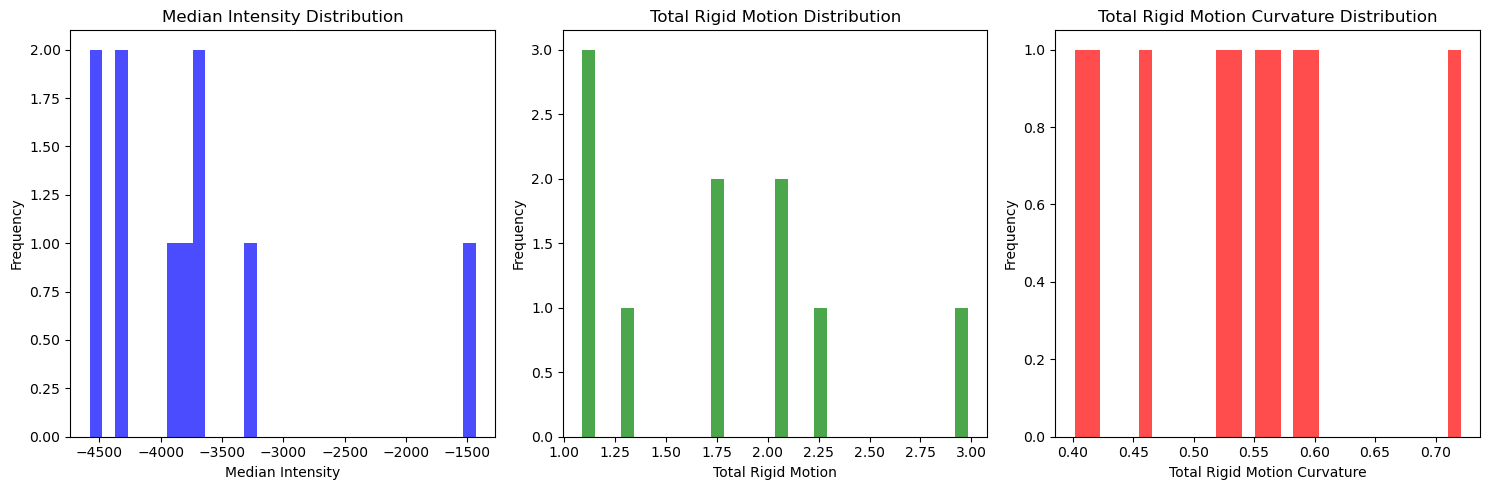

In [26]:
mjob = cs_project.find_job(mjob_id)
mjob_dir = mjob.dir()
istats = mjob.download_dataset('micrographs_rigid_aligned.cs')
median_intensity = []
total_rigid_motion = []
total_rigid_motion_curvature = []
pd_istats = pd.DataFrame(istats.rows())
temp_npy = "temp.npy"
for index, row in pd_istats.iterrows():
    # median intensity
    median_intensity.append(0.5 * (row["micrograph_blob/vmax"] + row["micrograph_blob/vmin"]))
    # motion
    mjob.download_file(row["rigid_motion/path"][5:], temp_npy) # download locally temporally
    rigid_motion = np.load(temp_npy)
    total_rigid_motion.append(
        np.sqrt((np.diff(rigid_motion, n=1, axis=1)**2).sum(axis=2)).sum()
    )
    total_rigid_motion_curvature.append(
        np.sqrt((np.diff(rigid_motion, n=2, axis=1)**2).sum(axis=2)).sum()
    )
if os.path.exists(temp_npy):
    os.unlink(temp_npy)
    
median_intensity = np.array(median_intensity)
total_rigid_motion = np.array(total_rigid_motion)
total_rigid_motion_curvature = np.array(total_rigid_motion_curvature)
plt.figure(figsize=(15, 5))

# Histogram for Median Intensity
plt.subplot(1, 3, 1)
plt.hist(median_intensity, bins=30, color='blue', alpha=0.7)
plt.title('Median Intensity Distribution')
plt.xlabel('Median Intensity')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(total_rigid_motion, bins=30, color='green', alpha=0.7)
plt.title('Total Rigid Motion Distribution')
plt.xlabel('Total Rigid Motion')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.hist(total_rigid_motion_curvature, bins=30, color='red', alpha=0.7)
plt.title('Total Rigid Motion Curvature Distribution')
plt.xlabel('Total Rigid Motion Curvature')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## CTF Estimation

In [27]:
cjob = cs_workspace.create_job(
        "patch_ctf_estimation_multi",
        connections={
            "exposures": (mjob_id, "micrographs")
        },
        params={
            "compute_num_gpus": 1,
        }
    )
cjob_id = cjob.uid
html_link = get_cryosparc_job_link(project_id, workspace_id, cjob_id)
display(Markdown(html_link))
cjob.queue("default")
cjob.wait_for_done(error_on_incomplete=True)

[Click here to view the job](http://localhost:39000/browse/P10-W2-J*#job(P10-J787))

'completed'

### CTF Estimation Statistics  

After performing CTF estimation, we can calculate four key statistics to evaluate the quality of the micrographs and the accuracy of the CTF fitting:  

1. **CTF Fit Resolution**:  
   This metric represents the spatial frequency at which the correlation between the micrograph's power spectrum and the ideal CTF (estimated via Patch CTF Estimation) drops to 0.3. It provides an estimate of the image quality but is not a strict resolution limit. For example:  
   - High CTF fit resolution may indicate the presence of a carbon layer.  
   - Low CTF fit resolution could result from crystalline ice, failed motion correction, or severe radiation damage.  

2. **Tilt Angle**:  
   The tilt angle refers to the angle between the tilt axis and the image coordinate axes. Unlike beam tilt or coma aberration in cryo-EM, this angle is unique to the sample stage tilt used in some single-particle analysis (SPA) experiments to mitigate preferred orientation issues. CryoSPARC estimates the tilt angle indirectly by fitting the defocus landscape during Patch CTF estimation. Specifically:  
   - CryoSPARC computes the defocus tilt normal vector, \([normal[0], normal[1], -1]\), which represents the plane normal in x, y, and z coordinates.  
   - The tilt angle is derived by normalizing this vector and calculating its dot product with the unit normal vector \([0, 0, -1]\).  

3. **Defocus Range**:  
   The defocus range is the difference between the maximum and minimum defocus values measured across the micrograph during Patch CTF Estimation. It reflects the variation in focus within the image. A large defocus range may indicate uneven focusing, leading to regions with varying contrast and potentially affecting downstream processing.  

4. **Astigmatism**:  
   Astigmatism arises from lens asymmetry and manifests as focal shifts in certain regions of the image. In the frequency domain, it results in elliptical distortion. Severe astigmatism can cause image blurring, negatively impacting the quality of subsequent reconstructions.  

These statistics are critical for assessing the quality of CTF estimation and identifying potential issues in the micrographs.

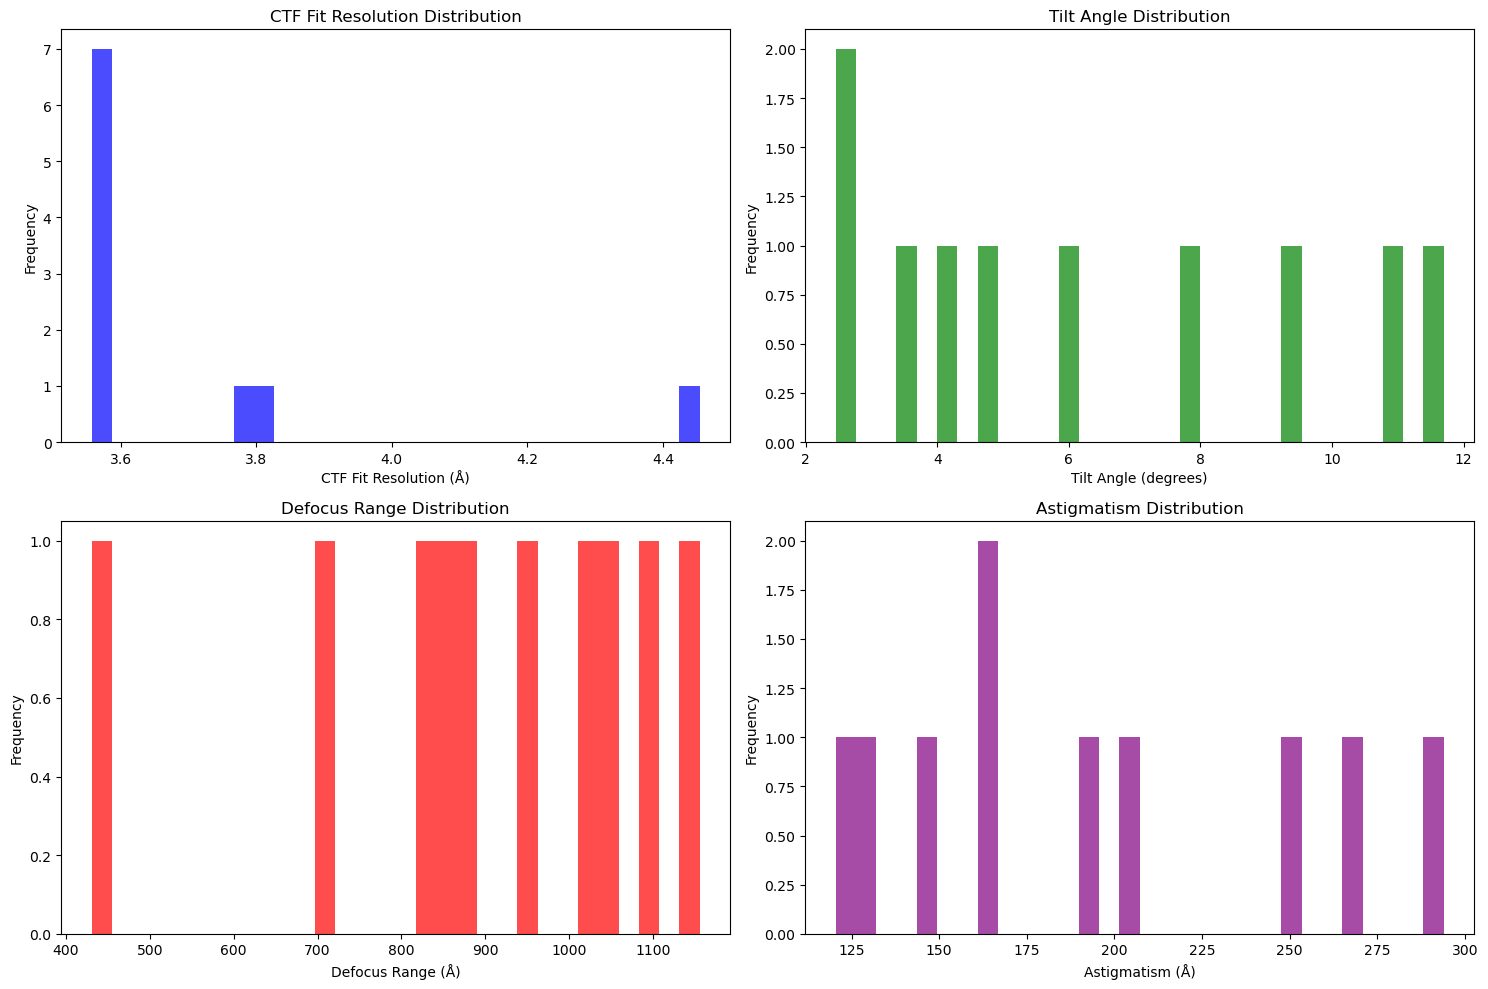

In [30]:
cjob = cs_project.find_job(cjob_id)
ctfstats = cjob.download_dataset("exposures_ctf_estimated.cs")
pd_ctfstats = pd.DataFrame(ctfstats.rows())
ctf_fit_resolution = []
tilt_angle = []
defocus_range = []
astigmatism = []
for index, row in pd_ctfstats.iterrows():
    # CTF Fit Resolution
    ctf_fit_resolution.append(
        row['ctf/ctf_fit_to_A']
    )
    # Tilt Angle
    tilt_normal_y = row['ctf_stats/df_tilt_normal'].astype(float).tolist()[0]
    tilt_normal_x = row['ctf_stats/df_tilt_normal'].astype(float).tolist()[1]
    tilt_magnitude = np.sqrt(tilt_normal_x**2 + tilt_normal_y**2)
    tilt_angle.append(
        np.rad2deg(np.arctan(tilt_magnitude))
    )
    # Defocus Range
    defocus_2d_landscape_u = row['ctf_stats/df_range'].astype(float).tolist()[0]
    defocus_2d_landscape_v = row['ctf_stats/df_range'].astype(float).tolist()[1]
    defocus_range.append(
        abs(defocus_2d_landscape_u - defocus_2d_landscape_v)
    )
    # Astigmatism (absolute value)
    astigmatism.append(
        abs(row['ctf/df1_A'] - row['ctf/df2_A'])
    )
ctf_fit_resolution = np.array(ctf_fit_resolution)
tilt_angle = np.array(tilt_angle)
defocus_range = np.array(defocus_range)
astigmatism = np.array(astigmatism)

# Plot histograms for CTF estimation statistics
plt.figure(figsize=(15, 10))

# Histogram for CTF Fit Resolution
plt.subplot(2, 2, 1)
plt.hist(ctf_fit_resolution, bins=30, color='blue', alpha=0.7)
plt.title('CTF Fit Resolution Distribution')
plt.xlabel('CTF Fit Resolution (Å)')
plt.ylabel('Frequency')

# Histogram for Tilt Angle
plt.subplot(2, 2, 2)
plt.hist(tilt_angle, bins=30, color='green', alpha=0.7)
plt.title('Tilt Angle Distribution')
plt.xlabel('Tilt Angle (degrees)')
plt.ylabel('Frequency')

# Histogram for Defocus Range
plt.subplot(2, 2, 3)
plt.hist(defocus_range, bins=30, color='red', alpha=0.7)
plt.title('Defocus Range Distribution')
plt.xlabel('Defocus Range (Å)')
plt.ylabel('Frequency')

# Histogram for Astigmatism
plt.subplot(2, 2, 4)
plt.hist(astigmatism, bins=30, color='purple', alpha=0.7)
plt.title('Astigmatism Distribution')
plt.xlabel('Astigmatism (Å)')
plt.ylabel('Frequency')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()
